In [20]:

import pandas as pd
from zoneinfo import ZoneInfo

import mplfinance as mpf
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [21]:
import sys
from pathlib import Path

project_dir = Path().resolve().parent
sys.path.append(str(project_dir))

# import my own modules
from CommonFunc.db_handler import DbHandler
from CommonFunc.fetch_update import FetcherUpdater

#### 0. Getting Data and Process Date Columns

In [25]:
import os

# using absolute db path
db_file = os.path.join(project_dir, "Data\crypto.db") 
db = DbHandler(db_file)
fetch_update = FetcherUpdater(db_file)

crypto = 'SOL'
crypto_lower = 'sol'

update_df = fetch_update.add_price_data(crypto=f'{crypto}', table=f'{crypto_lower}_hourly')
print(update_df)

            time                    utc_dt                    nyc_dt    high  \
1995  1738263600 2025-01-30 19:00:00+00:00 2025-01-30 14:00:00-05:00  241.39   
1996  1738267200 2025-01-30 20:00:00+00:00 2025-01-30 15:00:00-05:00  241.24   
1997  1738270800 2025-01-30 21:00:00+00:00 2025-01-30 16:00:00-05:00  240.67   
1998  1738274400 2025-01-30 22:00:00+00:00 2025-01-30 17:00:00-05:00  242.21   
1999  1738278000 2025-01-30 23:00:00+00:00 2025-01-30 18:00:00-05:00  240.83   
2000  1738281600 2025-01-31 00:00:00+00:00 2025-01-30 19:00:00-05:00  238.97   

         low    open   close  volumefrom     volumeto         avg  
1995  238.91  241.11  241.13    86741.00  20830538.59  240.146397  
1996  238.51  241.13  238.72    69765.15  16720518.69  239.668641  
1997  238.70  238.72  240.51    44032.08  10558777.38  239.797379  
1998  239.62  240.51  240.03    89154.02  21464352.72  240.755860  
1999  238.33  240.03  238.36    34571.42   8293005.16  239.880374  
2000  237.78  238.36  237.85   

In [ ]:
# save to db if there's updated data
if not update_df.empty:
    db.save_to_db(update_df, 'sol_hourly')
else:
    print('Data is up-to-date')

In [ ]:
# query price data
query = "SELECT * FROM sol_hourly order by time" # contains hourly data from 2021
df = db.read_from_db(query)

# convert dt columns types to datetime
df['utc_dt'] = pd.to_datetime(df['utc_dt'])
df['nyc_dt'] = df['utc_dt'].apply(lambda x: x.astimezone(ZoneInfo("America/New_York")))

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35712 entries, 0 to 35711
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        35712 non-null  int64  
 1   utc_dt      35712 non-null  object 
 2   nyc_dt      35712 non-null  object 
 3   high        35712 non-null  float64
 4   low         35712 non-null  float64
 5   open        35712 non-null  float64
 6   close       35712 non-null  float64
 7   volumefrom  35712 non-null  float64
 8   volumeto    35712 non-null  float64
 9   avg         35712 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 2.7+ MB
None


#### 1. Compute Technical Metrics

In [10]:
# 1. SMA: simple moving average
df['sma_24'] = df['close'].rolling(window=24).mean()  # 24-hour SMA
df['sma_72'] = df['close'].rolling(window=72).mean()  # 3-day SMA

# EMA: exponential moving average
df['ema_24'] = df['close'].ewm(span=24, adjust=False).mean()
df['ema_72'] = df['close'].ewm(span=72, adjust=False).mean()

# 2. RSI: Relative Strength Index
window = 14
delta = df['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
rs = gain / loss
df['rsi'] = 100 - (100 / (1 + rs))

# 3. MACD: moving average convergence divergence
short_ema = df['close'].ewm(span=12, adjust=False).mean()
long_ema = df['close'].ewm(span=26, adjust=False).mean()
df['macd'] = short_ema - long_ema
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

# 4. Bollinger Bands
sma = df['close'].rolling(window=20).mean()
std_dev = df['close'].rolling(window=20).std()
df['bollinger_upper'] = sma + (std_dev * 2)
df['bollinger_lower'] = sma - (std_dev * 2)

# 5. volume analysis
df['volumefrom_sma_24'] = df['volumefrom'].rolling(window=24).mean()
df['volumefrom_sma_72'] = df['volumefrom'].rolling(window=72).mean()

df.tail()


#### 2. Visualization

2.1 Visualization of candlestick chart with volume and MA

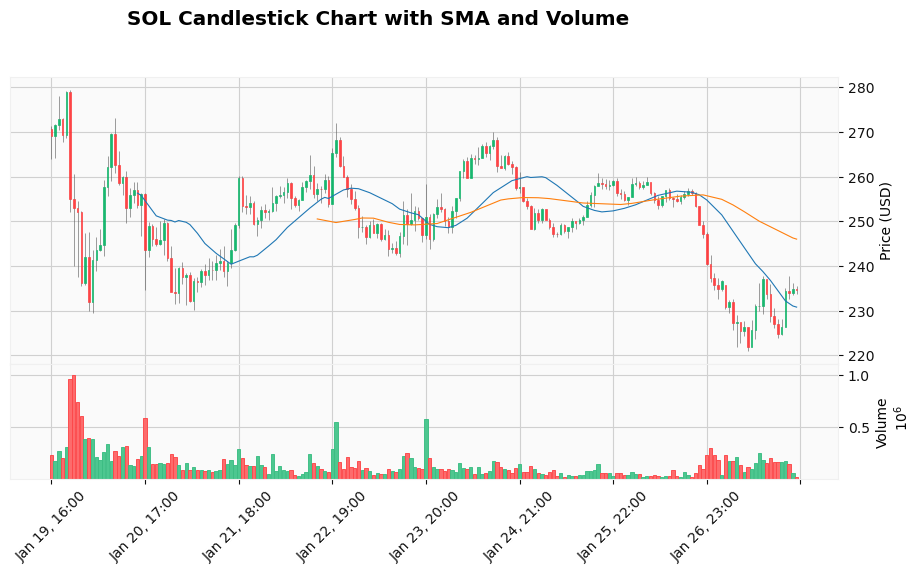

In [17]:
# Ensure required columns exist
df['date'] = df['utc_dt']  # or 'nyc_dt' for local time
ohlc_data = df[['utc_dt', 'open', 'high', 'low', 'close', 'volumefrom']].rename(columns={
    'utc_dt': 'date',  # Ensure column for the index is named 'date'
    'volumefrom': 'volume'  # Rename volume column
}).set_index('date')

# Plot with SMA and Bollinger Bands
mpf.plot(
    ohlc_data[-200:],  # Last 100 hours for clarity
    type='candle',
    mav=(24, 72),  # SMA lines
    volume=True,
    style='yahoo',
    title=f'{crypto} Candlestick Chart with SMA and Volume',
    ylabel='Price (USD)',
    ylabel_lower='Volume',
    figratio=(18,9)
)


2.2 Visualization of RSI and MACD

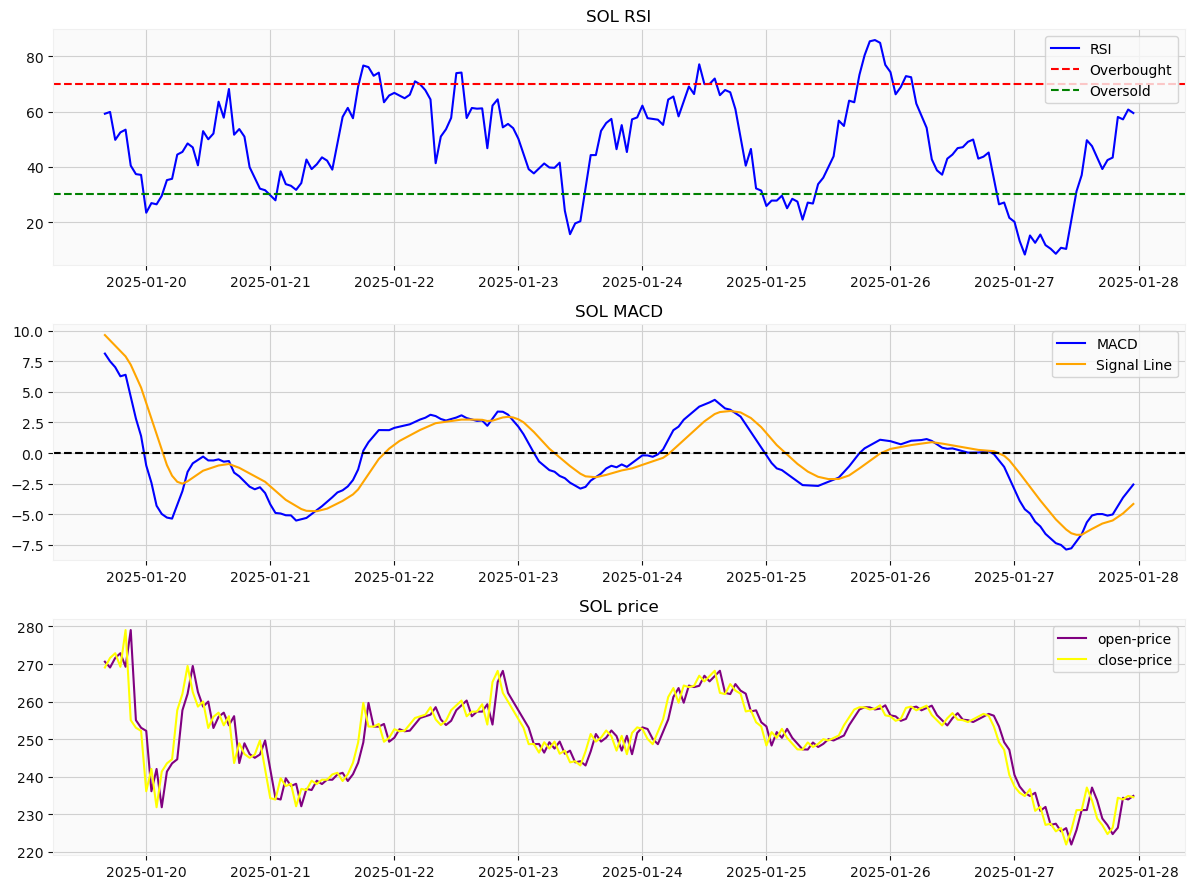

In [18]:
plt_df = df[-200:]

# Plot RSI
plt.figure(figsize=(12, 9))
plt.subplot(3, 1, 1)
plt.plot(plt_df['utc_dt'], plt_df['rsi'], label='RSI', color='blue')
plt.axhline(70, color='red', linestyle='--', label='Overbought')
plt.axhline(30, color='green', linestyle='--', label='Oversold')
plt.title(f'{crypto} RSI')
plt.legend()

# Plot MACD
plt.subplot(3, 1, 2)
plt.plot(plt_df['utc_dt'], plt_df['macd'], label='MACD', color='blue')
plt.plot(plt_df['utc_dt'], plt_df['macd_signal'], label='Signal Line', color='orange')
plt.axhline(0, color='black', linestyle='--')
plt.title(f'{crypto} MACD')
plt.legend()

# plot price
plt.subplot(3, 1, 3)
plt.plot(plt_df['utc_dt'], plt_df['open'], label='open-price', color='purple')
plt.plot(plt_df['utc_dt'], plt_df['close'], label='close-price', color='yellow')
plt.title(f'{crypto} price')
plt.legend()

plt.tight_layout()
plt.show()


2.3 Visualization of Bollinger Bands

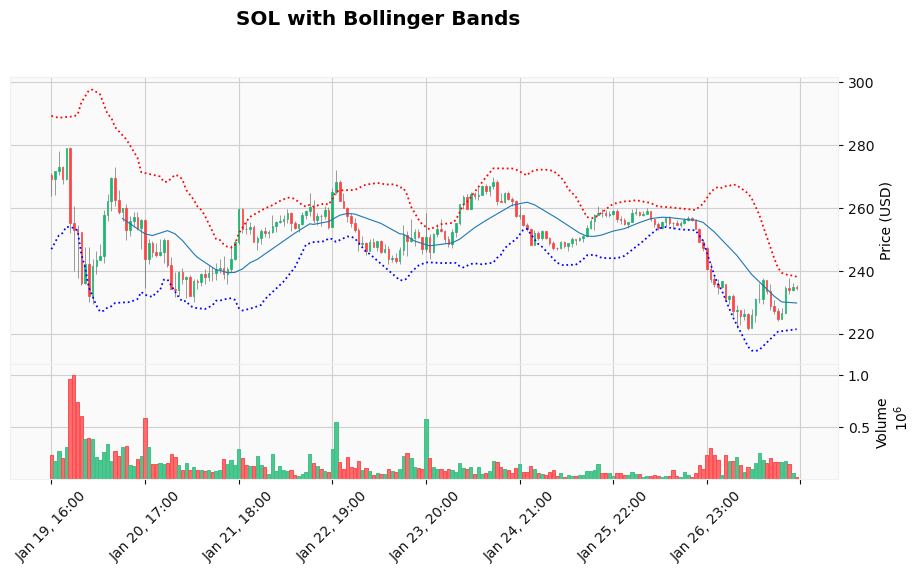

In [19]:
df['date'] = df['utc_dt']  # or 'nyc_dt' for local time
ohlc_data = df.rename(columns={
    'volumefrom': 'volume'  # Rename volume column
}).set_index('date')

mpf.plot(
    ohlc_data[-200:],  # Last 200 rows
    type='candle',
    style='yahoo',
    mav=(20),  # Middle Band (20-period SMA)
    volume=True,
    addplot=[
        mpf.make_addplot(ohlc_data['bollinger_upper'][-200:], color='red', linestyle='dotted'),
        mpf.make_addplot(ohlc_data['bollinger_lower'][-200:], color='blue', linestyle='dotted'),
    ],
    title=f'{crypto} with Bollinger Bands',
    ylabel='Price (USD)',
    ylabel_lower='Volume',
    figratio=(18,9)
)

#### 3. Validate trading signals of each metric